# **SkimLit Project**

The purpose of this notebook is to build an NLP Model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

and reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251#

In [1]:
## Confirm access to a GPU

!nvidia-smi

Fri Jan 17 09:59:34 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Get the data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

we can do so from the GitHub:https://github.com/Franck-Dernoncourt/pubmed-rct



## Abstract

**PubMed 200k RCT** is new dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion.

Classes in the dataset: **`background`**, **`objective`**, **`method`**, **`result`**, and **`conclusion`**.

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 19.44 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [4]:
# Check what files are in the PubMed_20K dataset

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/ # dev.txt is for validation set
# !ls /content/pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [5]:
# Start our experiments using the 20K dataset with numbers replaced by '@' sign

data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [6]:
# Check all of the filenames in the target directory
import os
import numpy as np
import tensorflow as tf
import pandas as pd

filenames = [data_dir + '/' +filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess Data

In [7]:
# Create function to read the lines of a document

def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """

  with open(filename,'r') as file:
    return file.readlines()

In [8]:
# Lets read in the training lines

train_lines = get_lines(data_dir + '/' + "train.txt") # read the lines with the training file

train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Let's think about how we want our data to look...

How i think our data would be best represented...

```
[{
  'line_number' : 0,
  'target' : 'BACKGROUND',
  'text' : "Emotional eating is associated with overeating and the development of obesity. \n",
  'total_lines' : 11 },
  ...
]

```

In [10]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number the target line is.

  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file

  for line in input_lines:
    if line.startswith('###'): # Check to see if this is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split the abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_num, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split the target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_num # what number line does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions arent fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [11]:
# Get data from file and process it

%%time

train_path = data_dir + '/' + 'train.txt'
test_path = data_dir + '/' + 'test.txt'
val_path = data_dir + '/' + 'dev.txt' # dev is another name for validation dataset

train_samples = preprocess_text_with_line_numbers(train_path)
test_samples = preprocess_text_with_line_numbers(test_path)
val_samples = preprocess_text_with_line_numbers(val_path)

print(len(train_samples), len(test_samples), len(val_samples))

180040 30135 30212
CPU times: user 584 ms, sys: 120 ms, total: 705 ms
Wall time: 2.35 s


In [12]:
train_samples[:12]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [13]:
for samples in train_samples[:20]:
  print(samples['text'])

to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .
a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
pain was assessed using the visual analog pain scale ( @-@ mm ) .
secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .
serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .
there was a clinically relevant reduction in

In [14]:
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

In [15]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [16]:
test_df

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17
30131,RESULTS,there were no statistically significant betwee...,14,17
30132,RESULTS,there was no significant association between s...,15,17
30133,RESULTS,no adverse effects were reported .,16,17


In [17]:
val_df

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9
...,...,...,...,...
30207,RESULTS,pruritus occurred more frequently with the act...,9,13
30208,RESULTS,three patients in the active-regimen group ( @...,10,13
30209,RESULTS,hemoglobin values of grade @ ( @ to < @ g per ...,11,13
30210,CONCLUSIONS,rates of response to a @-week interferon-free ...,12,13


In [18]:
val_df

,target,text,line_number,total_lines
0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,0,9
1,BACKGROUND,it is not clear whether these patients would b...,1,9
2,OBJECTIVE,we sought to determine whether a @-month cours...,2,9
3,METHODS,asthmatic patients who were ige sensitized to ...,3,9
4,METHODS,primary outcomes were improvement in quality o...,4,9
...,...,...,...,...
30207,RESULTS,pruritus occurred more frequently with the act...,9,13
30208,RESULTS,three patients in the active-regimen group ( @...,10,13
30209,RESULTS,hemoglobin values of grade @ ( @ to < @ g per ...,11,13
30210,CONCLUSIONS,rates of response to a @-week interferon-free ...,12,13


In [19]:
# Distribution of labels in training data

train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


In [20]:
train_df.shape, test_df.shape, val_df.shape

((180040, 4), (30135, 4), (30212, 4))

<Axes: ylabel='Frequency'>

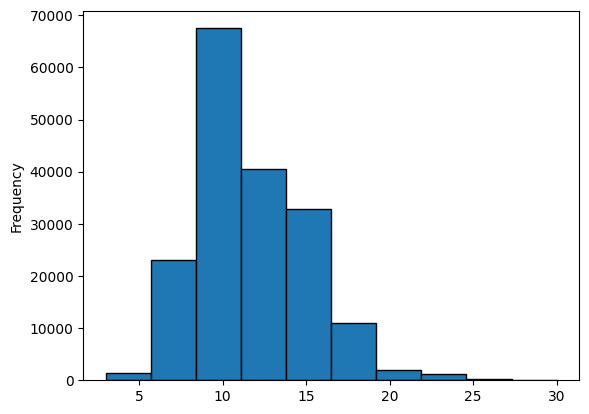

In [21]:
# Lets check the length of different lines

train_df.total_lines.plot(kind = 'hist', edgecolor = 'k', lw = 0.5, bins = 10)

## Get list of sentences

In [22]:
# Convert abstract text lines into lists

train_sentences = train_df.text.tolist()
test_sentences = test_df.text.tolist()
val_sentences = val_df.text.tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [23]:
# View 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [24]:
## One hot encoded labels

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1,1))

# check what one hot encoded labels look
train_labels_one_hot, val_labels_one_hot, test_labels_one_hot

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]))

In [25]:
# import tensorflow as tf

# tf.constant(train_labels_one_hot)

## Label encode labels

In [26]:
# Extract labels ("target" columns) and encode them into integers

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
val_labels_encoded = label_encoder.transform(val_df.target.to_numpy())
test_labels_encoded = label_encoder.transform(test_df.target.to_numpy())

In [27]:
train_labels_encoded, val_labels_encoded, test_labels_encoded

(array([3, 2, 2, ..., 4, 1, 1]),
 array([0, 0, 3, ..., 4, 1, 1]),
 array([0, 4, 4, ..., 4, 4, 1]))

In [28]:
np.unique(train_labels_encoded, return_counts = True)

(array([0, 1, 2, 3, 4]), array([21727, 27168, 59353, 13839, 57953]))

In [29]:
num_classes = len(label_encoder.classes_) # Number of classes that we have
class_names = label_encoder.classes_ # Name of the class
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [30]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (**`TF-IDF Multinomial Naive Bayes classifier`**).

## `Model 0` : Getting a baseline

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a Pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data

model_0.fit(X = train_sentences, y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [32]:
## Evaluate baseline model on validation dataset

model_0.score(X = val_sentences, y = val_labels_encoded)

0.7218323844829869

In [33]:
# Make preidictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [34]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [35]:
### Download helper function script

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-01-17 10:00:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-17 10:00:20 (116 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [36]:
from helper_functions import calculate_results

In [37]:
# Calculate baseline results

baseline_results = calculate_results(y_true = val_labels_encoded, y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [38]:
from tensorflow.keras import layers

In [39]:
## How long is each sentence on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [40]:
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

In [41]:
## Whats the distribution looks like?

import matplotlib.pyplot as plt

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

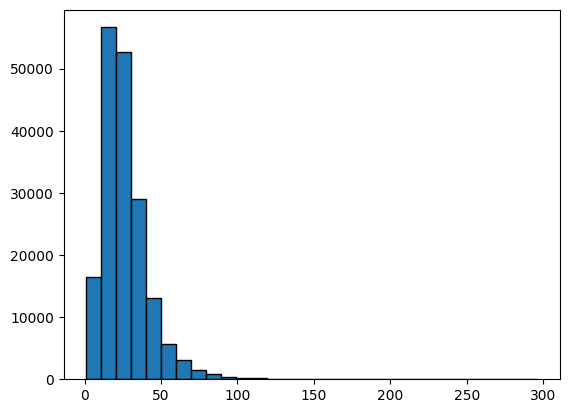

In [42]:
plt.hist(sent_lens, bins = 30, edgecolor = 'k', lw = 0.5)

In [43]:
# How long of a sentence length covers 95% of examples

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [44]:
# Maximum and Minimum sequence length in training sets

max(sent_lens), min(sent_lens)

(296, 1)

## Create text vectorizer layer

we want to make a layer which maps our texts from words to numbers.

In [45]:
## how many words are in our vocabulary? (taken from table 2 of this paper: https://arxiv.org/pdf/1710.06071)

max_tokens = 68000

In [46]:
# Create text vectorizer

from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens = max_tokens, # number of words in vocabulary
    output_sequence_length = output_seq_len, # desired output length of vectorized sequences
    output_mode = 'int',
    pad_to_max_tokens = True
    )

In [47]:
# Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [48]:
# Test out text vectorizer on random sentences
import random

random.seed(42)
target_sentence = random.choice(train_sentences)
print(f'Text: \n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text: 
this paper reports on the development , feasibility , acceptability , validity , and discriminant utility of a single item depression rating scale , delivered weekly via an automated sms system , as part of a large randomised controlled trial .

Length of text: 41

Vectorized text: [[   23  1716  1418    18     2   501   702  1449  1984     3 10013  2049
      4     8   312  1500   255   699   158   785   632   598    26  1863
   3069   355    25   732     4     8   545   210   106    32     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [49]:
# how many words are there in our vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocabulary: {len(rct_20k_text_vocab)}')

Number of words in vocabulary: 64841


In [50]:
print(f'Most common words in vocabulary: {rct_20k_text_vocab[:10]}')
print(f'Least common words in vocabulary: {rct_20k_text_vocab[-10:]}')

Most common words in vocabulary: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Least common words in vocabulary: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [51]:
# Get the config of our text vectorizer

text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Create custom text embedding

In [52]:
# Create token embedding layer

token_embed = layers.Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128, # Note: different embedding sizes result in drastically different number of parameters to train
    mask_zero = True, # This is a boolean flag. If set to True, it tells the embedding layer to ignore input tokens with a value of 0.
    name = 'token_embedding')

In [53]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization:\n {vectorized_sentence}')
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 this paper reports on the development , feasibility , acceptability , validity , and discriminant utility of a single item depression rating scale , delivered weekly via an automated sms system , as part of a large randomised controlled trial .

Sentence after vectorization:
 [[   23  1716  1418    18     2   501   702  1449  1984     3 10013  2049
      4     8   312  1500   255   699   158   785   632   598    26  1863
   3069   355    25   732     4     8   545   210   106    32     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding: 
 [[[-0.04728694 -0.00814296 -0.01846683 ... -0.01965263 -0.04673216
   -0.01470136]
  [ 0.00325351 -0.00563322  0.02810774 ...  0.00205213 -0.01795075
    0.02691403]
  [-0.02139434 -0.03056393  0.04320252 ... -0.04236137  0.04954538
   -0.04653437]
  ...
  [ 0.04791559 -0.00179821  0.02660979 ... -0.04627155  0.00452048

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow **`tf.data.API.`**

In [54]:
# Working Example for our dataset

# dt = [7,8,9,5,6,5,30,6,2]
dt = [[4,5],[7,8],[3,2],[1,5],[0,6],[9,7],[4,4],[1,2],[2,3],[7,5],[8,6],[2,3]]
labels = ['single','mingle','twinkle','double','triple','marble','stable','table','gargle','jingle','purple','rumble']

dataset = tf.data.Dataset.from_tensor_slices((dt, labels))
for data, labels in dataset:
  print(data.numpy(),':', labels.numpy().decode('utf-8'))

[4 5] : single
[7 8] : mingle
[3 2] : twinkle
[1 5] : double
[0 6] : triple
[9 7] : marble
[4 4] : stable
[1 2] : table
[2 3] : gargle
[7 5] : jingle
[8 6] : purple
[2 3] : rumble


In [55]:
# Turn our data into Tensorflow Datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [56]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [57]:
# Take the TensorSliceDataset's and turn them into prefetched datasets

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [58]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model_1: Conv1D with token embeddings

In [59]:
# Create 1D conv model to process sequences

inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # vectorize the text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layers
outputs = layers.Dense(num_classes, activation = 'softmax')(x)

model_1 = tf.keras.Model(inputs, outputs, name = 'model_1')

In [60]:
# Compile the model

model_1.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [61]:
model_1.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_embedding (Embedding)          │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Fit the model

history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch = int(0.1 * len(train_dataset)), # trained on 10% of train batches
    epochs = 5,
    validation_data = valid_dataset,
    validation_steps = int(0.1 * len(valid_dataset)) # only validate on 10% of batches
    )

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5147 - loss: 1.1711 - val_accuracy: 0.7384 - val_loss: 0.6879
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7469 - loss: 0.6839 - val_accuracy: 0.7650 - val_loss: 0.6348
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7728 - loss: 0.6205 - val_accuracy: 0.7909 - val_loss: 0.5880
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7891 - loss: 0.5944 - val_accuracy: 0.8029 - val_loss: 0.5631
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7913 - loss: 0.5871 - val_accuracy: 0.7955 - val_loss: 0.5659


In [63]:
# Evaluate on whole validation dataset

model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7997 - loss: 0.5583


[0.5603085160255432, 0.8010393381118774]

In [64]:
# Make predictions (our model predicts prediction probabilities for each class)

model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


(array([[5.3724283e-01, 1.7506418e-01, 5.9379719e-02, 1.5547819e-01,
         7.2835058e-02],
        [4.4900146e-01, 3.5775408e-01, 2.0497624e-02, 1.3967486e-01,
         3.3071961e-02],
        [1.9802630e-01, 5.8681802e-03, 2.1063017e-03, 7.9392773e-01,
         7.1455841e-05],
        ...,
        [4.3090135e-05, 6.5965398e-04, 5.9196418e-03, 2.2418211e-05,
         9.9335515e-01],
        [8.3944798e-02, 2.6384395e-01, 1.6629565e-01, 4.9589049e-02,
         4.3632653e-01],
        [1.2648796e-01, 7.7093488e-01, 6.4649776e-02, 1.0502227e-02,
         2.7425241e-02]], dtype=float32),
 (30212, 5))

In [65]:
# convert pred_probs to classes

model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [66]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [67]:
# Calculate results

model_1_results = calculate_results(y_true = val_labels_encoded, y_pred = model_1_preds.numpy())
model_1_results

{'accuracy': 80.10393221236595,
 'precision': 0.8019725023814536,
 'recall': 0.8010393221236595,
 'f1': 0.7977253840233447}

In [68]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model_2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the **`Universal Sentence Encoder (USE).`**

In [69]:
# Download pretrained TensorFlow Hub USE(Universal Sentence Encoder)

import tensorflow_hub as hub

url = "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2" # Universal Sentence Encoder

tf_hub_embedding_layer = hub.KerasLayer(
    url,
    input_shape = [],
    dtype = tf.string,
    trainable = False,
    name = 'USE'
)

In [70]:
# Test out the pretrained embedding on a random sentence

random_training_sentence = random.choice(train_sentences)
print(f'Random Sentence: \n {random_training_sentence}')

use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f'Embedded Sentence: \n {use_embedded_sentence[0][:50]}')

print(f'Length of embedded sentence: {len(use_embedded_sentence[0])}')

Random Sentence: 
 @ patients were enrolled and randomly assigned between nov @ , @ , and nov @ , @ ( @ to the lenalidomide group and @ to the control group ) , and @ patients received study treatment ( @ in the lenalidomide group and @ in the placebo group ) .
Embedded Sentence: 
 [-0.05329226  0.03086914  0.00237596 -0.03798862  0.0343949   0.01602185
  0.05083598 -0.07276729 -0.06888602 -0.04010594  0.08023895 -0.07013645
  0.07866052  0.00887381 -0.01721752  0.07560826 -0.08060592 -0.059796
 -0.0355238  -0.05403221  0.05326276  0.05933057 -0.0094849  -0.04844245
 -0.03374129 -0.00138138 -0.01520994  0.07141545  0.07387227  0.01697831
  0.05029933  0.08079899  0.001719   -0.02133924 -0.02002762 -0.04251529
 -0.05985187 -0.06029017 -0.05440311 -0.05411516 -0.02881743  0.04194712
  0.0167275  -0.06092536 -0.01539651  0.07737944  0.02307042  0.06880326
 -0.01135344 -0.04100062]
Length of embedded sentence: 512


## Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub

In [71]:
# Define feature extraction model using TF Hub layer
import tf_keras

inputs = tf_keras.layers.Input(shape = [], dtype = tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize the text and create embedding of each sequence (512 long vector)
x = tf_keras.layers.Dense(128, activation = 'relu')(pretrained_embedding)
x = tf_keras.layers.Dense(64, activation = 'relu')(x)

outputs = tf_keras.layers.Dense(num_classes, activation = 'softmax')(x)

model_2 = tf_keras.Model(inputs, outputs, name = 'Model_2_USE_feature_extractor')

In [72]:
# Compile the model

model_2.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = tf_keras.optimizers.Adam()
)

In [73]:
model_2.summary()

Model: "Model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256872069 (979.89 MB)
Trainable params: 74245 (290.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_____________________________________________________

In [74]:
# Fit the model

history_model_2 = model_2.fit(
    train_dataset,
    steps_per_epoch = int(len(train_dataset)*0.1),
    validation_data = valid_dataset,
    validation_steps = int(len(valid_dataset)*0.1),
    epochs = 5
)

Epoch 1/5
562/562 [==============================] - 12s 15ms/step - loss: 0.8892 - accuracy: 0.6559 - val_loss: 0.7856 - val_accuracy: 0.6948
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7425 - accuracy: 0.7092 - val_loss: 0.7196 - val_accuracy: 0.7191
Epoch 3/5
562/562 [==============================] - 8s 14ms/step - loss: 0.7138 - accuracy: 0.7249 - val_loss: 0.6891 - val_accuracy: 0.7320
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.6812 - accuracy: 0.7409 - val_loss: 0.6645 - val_accuracy: 0.7463
Epoch 5/5
562/562 [==============================] - 9s 17ms/step - loss: 0.6878 - accuracy: 0.7347 - val_loss: 0.6481 - val_accuracy: 0.7470


In [75]:
# Evaluate on the whole validation dataset

model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.6567 - accuracy: 0.7476


[0.6567248702049255, 0.7475506663322449]

In [76]:
# Make predictions with our feature extraction model

model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 11ms/step


array([[6.5077960e-01, 2.0022313e-01, 1.7496394e-03, 1.3952881e-01,
        7.7188737e-03],
       [4.2255285e-01, 4.8895597e-01, 4.1346392e-03, 8.1054032e-02,
        3.3024834e-03],
       [4.0143764e-01, 3.3114620e-02, 4.6104558e-02, 5.0154603e-01,
        1.7797118e-02],
       ...,
       [7.9787493e-04, 1.5439275e-03, 5.2691936e-02, 4.1285696e-04,
        9.4455338e-01],
       [2.4229067e-03, 2.6924603e-02, 2.4397640e-01, 9.2369696e-04,
        7.2575241e-01],
       [1.4916292e-01, 7.4072999e-01, 9.5658906e-02, 1.1651600e-03,
        1.3282995e-02]], dtype=float32)

In [77]:
# Convert the prediction probabilities with feature extraction model

model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [78]:
model_2_results = calculate_results(y_true = val_labels_encoded, y_pred = model_2_preds.numpy())
model_2_results

{'accuracy': 74.75506421289553,
 'precision': 0.7440540190016106,
 'recall': 0.7475506421289554,
 'f1': 0.7424193020665183}

In [79]:
model_1_results

{'accuracy': 80.10393221236595,
 'precision': 0.8019725023814536,
 'recall': 0.8010393221236595,
 'f1': 0.7977253840233447}

In [80]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model_3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

previously we made token level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

## Creating a Character level Tokenizer

In [81]:
train_sentences[1]

'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'

In [82]:
list(train_sentences[1])

['a',
 ' ',
 't',
 'o',
 't',
 'a',
 'l',
 ' ',
 'o',
 'f',
 ' ',
 '@',
 ' ',
 'p',
 'a',
 't',
 'i',
 'e',
 'n',
 't',
 's',
 ' ',
 'w',
 'i',
 't',
 'h',
 ' ',
 'p',
 'r',
 'i',
 'm',
 'a',
 'r',
 'y',
 ' ',
 'k',
 'n',
 'e',
 'e',
 ' ',
 'o',
 'a',
 ' ',
 'w',
 'e',
 'r',
 'e',
 ' ',
 'r',
 'a',
 'n',
 'd',
 'o',
 'm',
 'i',
 'z',
 'e',
 'd',
 ' ',
 '@',
 ':',
 '@',
 ' ',
 ';',
 ' ',
 '@',
 ' ',
 'r',
 'e',
 'c',
 'e',
 'i',
 'v',
 'e',
 'd',
 ' ',
 '@',
 ' ',
 'm',
 'g',
 '/',
 'd',
 'a',
 'y',
 ' ',
 'o',
 'f',
 ' ',
 'p',
 'r',
 'e',
 'd',
 'n',
 'i',
 's',
 'o',
 'l',
 'o',
 'n',
 'e',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 '@',
 ' ',
 'r',
 'e',
 'c',
 'e',
 'i',
 'v',
 'e',
 'd',
 ' ',
 'p',
 'l',
 'a',
 'c',
 'e',
 'b',
 'o',
 ' ',
 'f',
 'o',
 'r',
 ' ',
 '@',
 ' ',
 'w',
 'e',
 'e',
 'k',
 's',
 ' ',
 '.']

In [83]:
' '.join(list(train_sentences[1]))

'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .'

In [84]:
# Make a function to split sentences into characters

def split_chars(text):
  return ' '.join(list(text))

In [85]:
# Text splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'@   p a t i e n t s   w e r e   e n r o l l e d   a n d   r a n d o m l y   a s s i g n e d   b e t w e e n   n o v   @   ,   @   ,   a n d   n o v   @   ,   @   (   @   t o   t h e   l e n a l i d o m i d e   g r o u p   a n d   @   t o   t h e   c o n t r o l   g r o u p   )   ,   a n d   @   p a t i e n t s   r e c e i v e d   s t u d y   t r e a t m e n t   (   @   i n   t h e   l e n a l i d o m i d e   g r o u p   a n d   @   i n   t h e   p l a c e b o   g r o u p   )   .'

In [86]:
# Split sequence-level data splits into character-level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [87]:
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [88]:
# Whats the average character length?

chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(chars_lens)
mean_char_lens

149.3662574983337

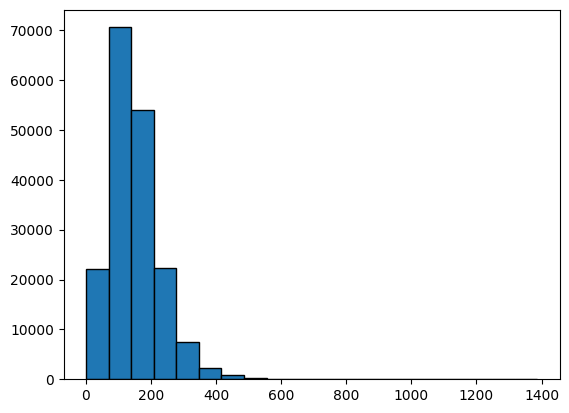

In [89]:
# Check the distribution of our sequences at a character level

import matplotlib.pyplot as plt

plt.hist(chars_lens, bins = 20, edgecolor = 'k', lw = 0.6)
plt.show()

In [90]:
# Find what character length covers 95% of sequences

output_seq_char_len = np.percentile(chars_lens,95)
output_seq_char_len = int(output_seq_char_len)
output_seq_char_len

290

In [91]:
# Get all keyboard characters
import string

alphabets = string.ascii_lowercase + string.digits + string.punctuation
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [92]:
# Create char-level token vectorizer instance

NUM_CHAR_TOKENS = len(alphabets) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')

char_vectorizer = TextVectorization(
    max_tokens = NUM_CHAR_TOKENS,
    standardize = 'lower_and_strip_punctuation',
    # standardize = None,
    output_sequence_length = output_seq_char_len,
    pad_to_max_tokens = True,
    name = 'char_vectorizer'
)

In [93]:
# Adapt character vectorizer to training character

char_vectorizer.adapt(train_chars)

In [94]:
# Check character vocab stats

char_vocab = char_vectorizer.get_vocabulary()
char_vocab

['',
 '[UNK]',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 'y',
 'w',
 'v',
 'b',
 'k',
 'x',
 'z',
 'q',
 'j']

In [95]:
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [96]:
# Test out character vectorizer

random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'\nLength of random_train_chars: {len(random_train_chars.split())}')

vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n {vectorized_chars}')
print(f'\nLength of vectorized chars:\n {len(vectorized_chars[0])}')

Charified text:
 i n   e a c h   p e r i o d   ,   s u b j e c t s   r e c e i v e d   @   m g   e n o x a p a r i n   (   i n   p a r t   @   )   ,   @ , @   u n i t s   u f h   (   i n   p a r t   @   )   ,   o r   p l a c e b o   f o l l o w e d   b y   @   o r   @   m g / k g   s u g a m m a d e x   ,   o r   p l a c e b o   .

Length of random_train_chars: 122

Vectorized chars:
 [[ 4  6  2  5 11 13 14  2  8  4  7 10  9 16 22 27  2 11  3  9  8  2 11  2
   4 21  2 10 15 18  2  6  7 24  5 14  5  8  4  6  4  6 14  5  8  3 16  6
   4  3  9 16 17 13  4  6 14  5  8  3  7  8 14 12  5 11  2 22  7 17  7 12
  12  7 20  2 10 22 19  7  8 15 18 23 18  9 16 18  5 15 15  5 10  2 24  7
   8 14 12  5 11  2 22  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0 

## Create a character-level embedding

In [97]:
# Create char embedding layer

char_embed = layers.Embedding(
    input_dim = len(char_vocab), # number of different characters
    output_dim = 25, # this is the size of the char embedding in the paper
    mask_zero = True,
    name = 'char-embed'
)

In [98]:
# Test out character embedding layer

print(f'charified text: \n {random_train_chars}\n')
print(f'\nlength of random_train_chars: {len(random_train_chars.split())}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding):\n {char_embed_example}\n')
print(f'Character embedding shape: {char_embed_example.shape}')

charified text: 
 i n   e a c h   p e r i o d   ,   s u b j e c t s   r e c e i v e d   @   m g   e n o x a p a r i n   (   i n   p a r t   @   )   ,   @ , @   u n i t s   u f h   (   i n   p a r t   @   )   ,   o r   p l a c e b o   f o l l o w e d   b y   @   o r   @   m g / k g   s u g a m m a d e x   ,   o r   p l a c e b o   .


length of random_train_chars: 122

Embedded chars (after vectorization and embedding):
 [[[-0.02300466  0.03545238 -0.02511903 ...  0.02150628 -0.00958322
   -0.02545899]
  [ 0.04794042 -0.0094417   0.02243641 ... -0.02648466  0.01795055
    0.01242922]
  [-0.03058821  0.02058642 -0.04135842 ... -0.00734121 -0.00359639
   -0.03927835]
  ...
  [ 0.02777939  0.02385018 -0.00165467 ... -0.00353865  0.02285222
    0.01946032]
  [ 0.02777939  0.02385018 -0.00165467 ... -0.00353865  0.02285222
    0.01946032]
  [ 0.02777939  0.02385018 -0.00165467 ... -0.00353865  0.02285222
    0.01946032]]]

Character embedding shape: (1, 290, 25)


## Building a Conv1D model to fit on character embeddings

In [99]:
# Make Conv1D on chars only

inputs = layers.Input(shape = (1,), dtype = 'string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(128, kernel_size = 5, padding = 'same', activation = 'relu')(char_embeddings)
# x = layers.GlobalAveragePooling1D()(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'model_3_conv1d_char_embeddings')

In [100]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 290)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char-embed (Embedding)               │ (None, 290, 25)             │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 290, 128)            │          16,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
## Compile the model

model_3.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = tf.keras.optimizers.Adam()
)

In [102]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [103]:
# Create char level datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [104]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [105]:
# Fit the model on chars only

model_3_history = model_3.fit(
    train_char_dataset,
    steps_per_epoch = int(0.1 * len(train_char_dataset)),
    validation_data = valid_char_dataset,
    validation_steps = int(0.1 * len(valid_char_dataset)),
    epochs = 10
)

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4395 - loss: 1.3539 - val_accuracy: 0.6147 - val_loss: 0.9787
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6120 - loss: 0.9796 - val_accuracy: 0.6669 - val_loss: 0.8758
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6581 - loss: 0.8767 - val_accuracy: 0.6775 - val_loss: 0.8378
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6857 - loss: 0.8287 - val_accuracy: 0.6978 - val_loss: 0.7841
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6941 - loss: 0.7953 - val_accuracy: 0.7021 - val_loss: 0.7788
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6996 - loss: 0.7844 - val_accuracy: 0.7197 - val_loss: 0.7242
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7008 - loss: 0.7681 - val_accuracy: 0.7254 - val_loss: 0.7227
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7163 - loss: 0.7436 - val_accuracy: 0.

In [106]:
# evaluate it on the validation charactere dataset
model_3.evaluate(valid_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7348 - loss: 0.7040


[0.7054510712623596, 0.7344763875007629]

In [107]:
# Make predictions with character model only

model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


array([[0.17419337, 0.6581811 , 0.01872953, 0.10021954, 0.0486765 ],
       [0.04493397, 0.9015621 , 0.00282009, 0.04243264, 0.0082513 ],
       [0.08719989, 0.05158336, 0.07007338, 0.78283256, 0.00831086],
       ...,
       [0.00206268, 0.00279391, 0.01077063, 0.00276002, 0.9816127 ],
       [0.01487095, 0.27435634, 0.18573707, 0.01196504, 0.5130706 ],
       [0.05812505, 0.8892096 , 0.04147146, 0.00881549, 0.00237839]],
      dtype=float32)

In [108]:
# Convert prediction probabilities to class labels

model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds.numpy()

array([1, 1, 3, ..., 4, 4, 1])

In [109]:
model_3_results = calculate_results(y_true = val_labels_encoded, y_pred = model_3_preds.numpy())
model_3_results

{'accuracy': 73.44763670064874,
 'precision': 0.7320563461705596,
 'recall': 0.7344763670064874,
 'f1': 0.7293626056177094}

## `Model_4` : Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to **`Model_1`**).
2. Create a character-level model (similar to **`Model_3`** with a slight modification).
3. Combine 1 & 2 with a concatenate (**`layers.concatenate`**).
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [110]:
token_embed2 = layers.Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128, # Note: different embedding sizes result in drastically different number of parameters to train
    name = 'token_embedding2')

In [111]:
char_embed2 = layers.Embedding(
    input_dim = len(char_vocab), # number of different characters
    output_dim = 25, # this is the size of the char embedding in the paper
    # mask_zero = True,
    name = 'char-embed'
)

In [112]:
# 1. Setup token inputs/model

token_inputs = layers.Input(shape = (1,), dtype = 'string', name = 'token_input')
# token_embeddings = tf_hub_embedding_layer(token_inputs)
text_vectors = text_vectorizer(token_inputs) # vectorize the text inputs
token_embeddings = token_embed2(text_vectors) # create embedding
# glob_average = layers.GlobalMaxPool1D()(token_embeddings)
glob_average = layers.GlobalAveragePooling1D()(token_embeddings)
token_output = layers.Dense(128, activation = 'relu')(glob_average)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_output)

# 2. Setup char inputs/model

char_inputs = layers.Input(shape = (1,), dtype = 'string', name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings2 = char_embed2(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24, return_sequences = True))(char_embeddings2) # Bi-LSTM shown in Figure-1 of  https://arxiv.org/pdf/1612.05251.pdf
glob_average = layers.GlobalAveragePooling1D()(char_bi_lstm)
# glob_average = layers.GlobalMaxPool1D()(char_bi_lstm)
char_model = tf.keras.Model(inputs = char_inputs, outputs = glob_average)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                    char_model.output])

# 4. Create output layers-adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = 'model_4_token_and_char_embeddings')

In [113]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ token_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 55)             │              0 │ token_input[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_embedding2          │ (None, 55, 128)        │      8,299,648 │ text_vectorization[1]… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char-embed (Embedding)    │ (None, 290, 25)        │            700 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ token_embedding2[0][0] │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 290, 48)        │          9,600 │ char-embed[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         16,512 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 48)             │              0 │ bidirectional[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 176)            │              0 │ dense_2[0][0],         │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 176)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         22,656 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 5)              │            645 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,349,761 (31.85 MB)

 Trainable params: 8,349,761 (31.85 MB)

 Non-trainable params: 0 (0.00 B)

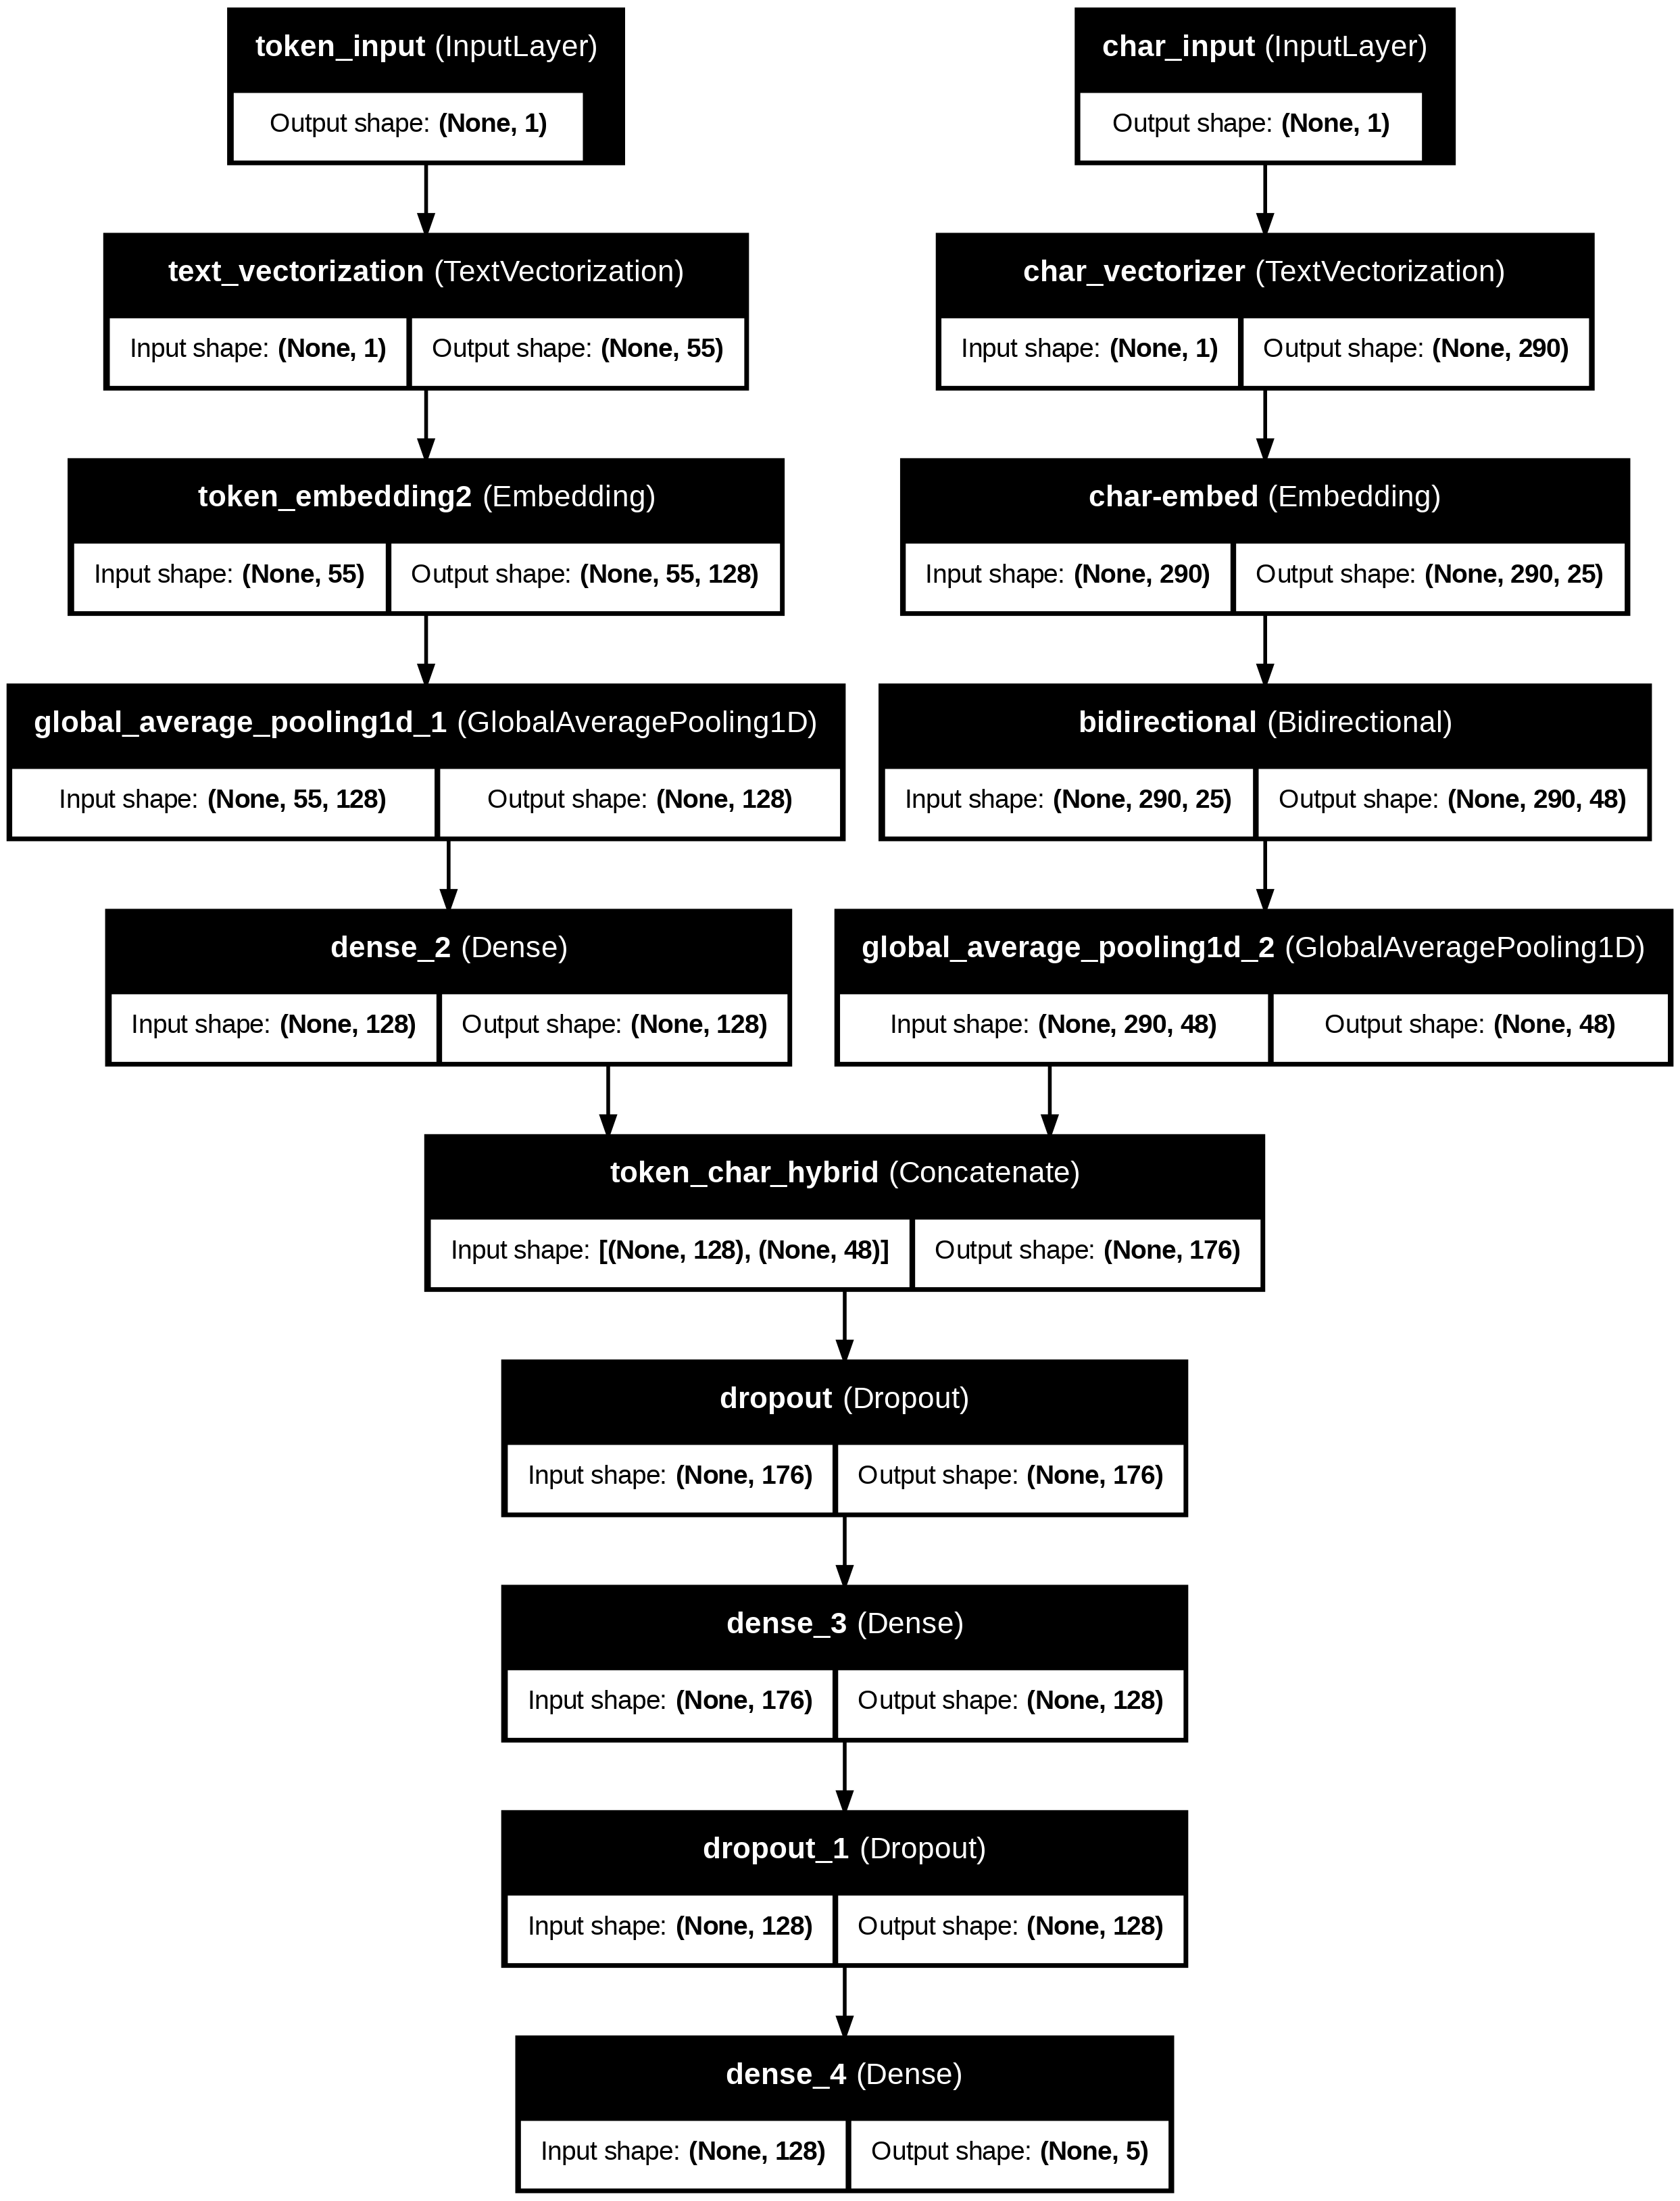

In [114]:
# Plot Hybrid token and character model

from tensorflow.keras.utils import plot_model

plot_model(model_4, show_shapes = True, show_layer_names = True)

In [115]:
# Compile token char model

model_4.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = tf.keras.optimizers.Adam()
)

## Combining token and character data into tf.data.Dataset

In [116]:
# Combine chars and tokens into a dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [117]:
# Repeat the above steps for validation data

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels

# Prefetch and batch valid data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [118]:
# Check out our training char and token embedding dataset

train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting the model on token and character-level sequences

In [119]:
# Fit the model on tokens and chars

model_4_history = model_4.fit(
    train_char_token_dataset,
    steps_per_epoch = int(0.1*len(train_char_token_dataset)),
    epochs = 5,
    validation_data = val_char_token_dataset,
    validation_steps = int(0.1*len(val_char_token_dataset))
)

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.3957 - loss: 1.3537 - val_accuracy: 0.6686 - val_loss: 0.7806
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.6690 - loss: 0.8195 - val_accuracy: 0.7487 - val_loss: 0.6730
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.7151 - loss: 0.7295 - val_accuracy: 0.6905 - val_loss: 0.7572
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.7307 - loss: 0.7069 - val_accuracy: 0.7716 - val_loss: 0.5937
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.7527 - loss: 0.6707 - val_accuracy: 0.7553 - val_loss: 0.6525


In [120]:
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7598 - loss: 0.6411


[0.6438601613044739, 0.7586720585823059]

In [121]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step


array([[4.81762797e-01, 2.40416646e-01, 1.90093126e-02, 2.49678195e-01,
        9.13311820e-03],
       [5.05488753e-01, 3.84727150e-01, 3.50693217e-03, 1.02200031e-01,
        4.07708855e-03],
       [3.24080020e-01, 4.55701444e-03, 2.65280181e-03, 6.68544531e-01,
        1.65631471e-04],
       ...,
       [2.65961298e-05, 7.12606171e-03, 5.10848593e-03, 3.12830002e-06,
        9.87735689e-01],
       [1.17804065e-01, 5.60281754e-01, 2.78319903e-02, 5.90400882e-02,
        2.35042140e-01],
       [4.21754211e-01, 5.28280973e-01, 6.42765127e-03, 3.47354226e-02,
        8.80176853e-03]], dtype=float32)

In [122]:
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [123]:
model_4_results = calculate_results(y_true = val_labels_encoded, y_pred = model_4_preds.numpy())
model_4_results

{'accuracy': 75.86720508407255,
 'precision': 0.778236673482856,
 'recall': 0.7586720508407255,
 'f1': 0.7637787332783522}

In [124]:
model_1_results

{'accuracy': 80.10393221236595,
 'precision': 0.8019725023814536,
 'recall': 0.8010393221236595,
 'f1': 0.7977253840233447}

In [125]:
model_2_results

{'accuracy': 74.75506421289553,
 'precision': 0.7440540190016106,
 'recall': 0.7475506421289554,
 'f1': 0.7424193020665183}

## `Model_5` : Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

**`Note:`** Any engineered features used to train a model need to be available at test time. In our case, **line numbers** and **total lines** are available.

### Create positional embeddings


In [126]:
# How many different line numbers are there?

train_df['line_number'].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

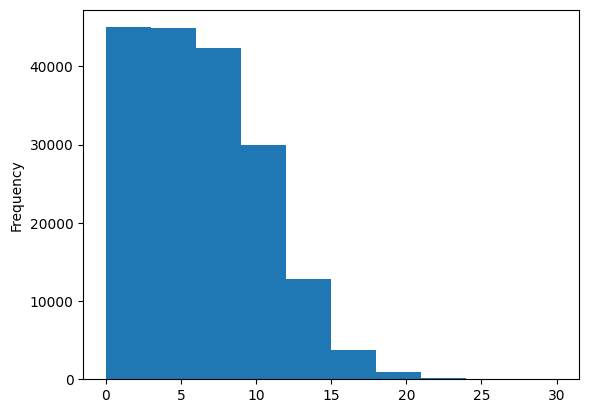

In [127]:
# Check the distribution of "line_number" column

train_df.line_number.plot(kind = 'hist')

In [128]:
# Use TensoFlow to create one-hot encoded tensors of line numbers

train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 20)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 20)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 20)
train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [129]:
val_line_numbers_one_hot

<tf.Tensor: shape=(30212, 20), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [130]:
test_line_numbers_one_hot

<tf.Tensor: shape=(30135, 20), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)>

Now we've encoded our line number features, let's do the same for our total line feature...

<Axes: ylabel='Frequency'>

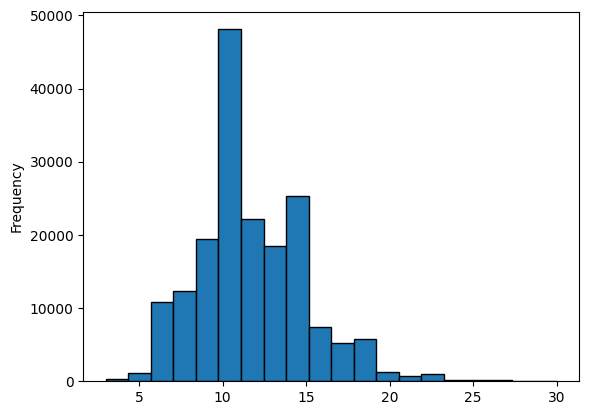

In [131]:
# How many different numbers of lines there are??

train_df['total_lines'].plot(kind = 'hist', edgecolor = 'k', lw = 0.6, bins = 20)

In [132]:
# Check the coverage of a "total_lines" value of 20

np.percentile(train_df.total_lines, 98)

20.0

In [133]:
# Use TensorFlow to create one-hot-encoded tensors of our 'total_lines' feature

train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)
train_total_lines_one_hot[-10:]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

## Building a tribid embedding model

1. Create a token-level model.
2. Create a character-level model.
3. Create a model for the 'line_number' feature.
4. Create a model for the 'total_lines' feature.
5. Combine the outputs for 1 and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of tf.keras.Model

In [144]:
# 1. Token_inputs

token_inputs = layers.Input(shape = [], dtype = 'string', name = 'token_inputs')
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed2(token_vectors)
global_average = layers.GlobalAveragePooling1D()(token_embeddings)
token_outputs = layers.Dense(128, activation = 'relu')(global_average)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = (1, ), dtype = 'string', name = 'char_inputs')
char_vectors  = char_vectorizer(char_inputs)
char_embeddings = char_embed2(char_vectors)
char_bi_lstm = layers.Bidirectional((layers.LSTM(24, return_sequences=True)))(char_embeddings)
global_avg = layers.GlobalAveragePooling1D()(char_bi_lstm)
char_model = tf.keras.Model(inputs = char_inputs, outputs = global_avg)

# 3. Line numbers Model
line_number_inputs = layers.Input(shape = (20,), dtype = tf.float32, name = 'line_number_input')
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation = 'relu')(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs = line_number_inputs, outputs = x)

# 4. Total Line numbers Model
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32, name = 'total_line_number_input')
y = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs, outputs = y)

# 5. Combine Token and Char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = 'char_token_hybrid_embedding')([token_model.output, char_model.output])

z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribid_embeddings = layers.Concatenate(name = 'char_token_positional_embedding')([
    line_number_model.output,
    total_lines_model.output,
    z
    ])

# 7. Create output_layer
output_layer = layers.Dense(5, activation = 'softmax', name = 'output_layer')(tribid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer, name = 'tribid_embedding_model')

In [145]:
# Lets get a summary of our tribid model
model_5.summary()

Model: "tribid_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ token_inputs (InputLayer) │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_inputs (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 55)             │              0 │ token_inputs[0][0]     │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_inputs[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_embedding2          │ (None, 55, 128)        │      8,299,648 │ text_vectorization[3]… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char-embed (Embedding)    │ (None, 290, 25)        │            700 │ char_vectorizer[3][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ token_embedding2[2][0] │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 290, 48)        │          9,600 │ char-embed[2][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 128)            │         16,512 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 48)             │              0 │ bidirectional_2[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_token_hybrid_embedd… │ (None, 176)            │              0 │ dense_9[0][0],         │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input         │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_line_number_input   │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 256)            │         45,312 │ char_token_hybrid_emb… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │            672 │ line_number_input[0][… │
├──────────────────────

 Total params: 8,374,721 (31.95 MB)

 Trainable params: 8,374,721 (31.95 MB)

 Non-trainable params: 0 (0.00 B)

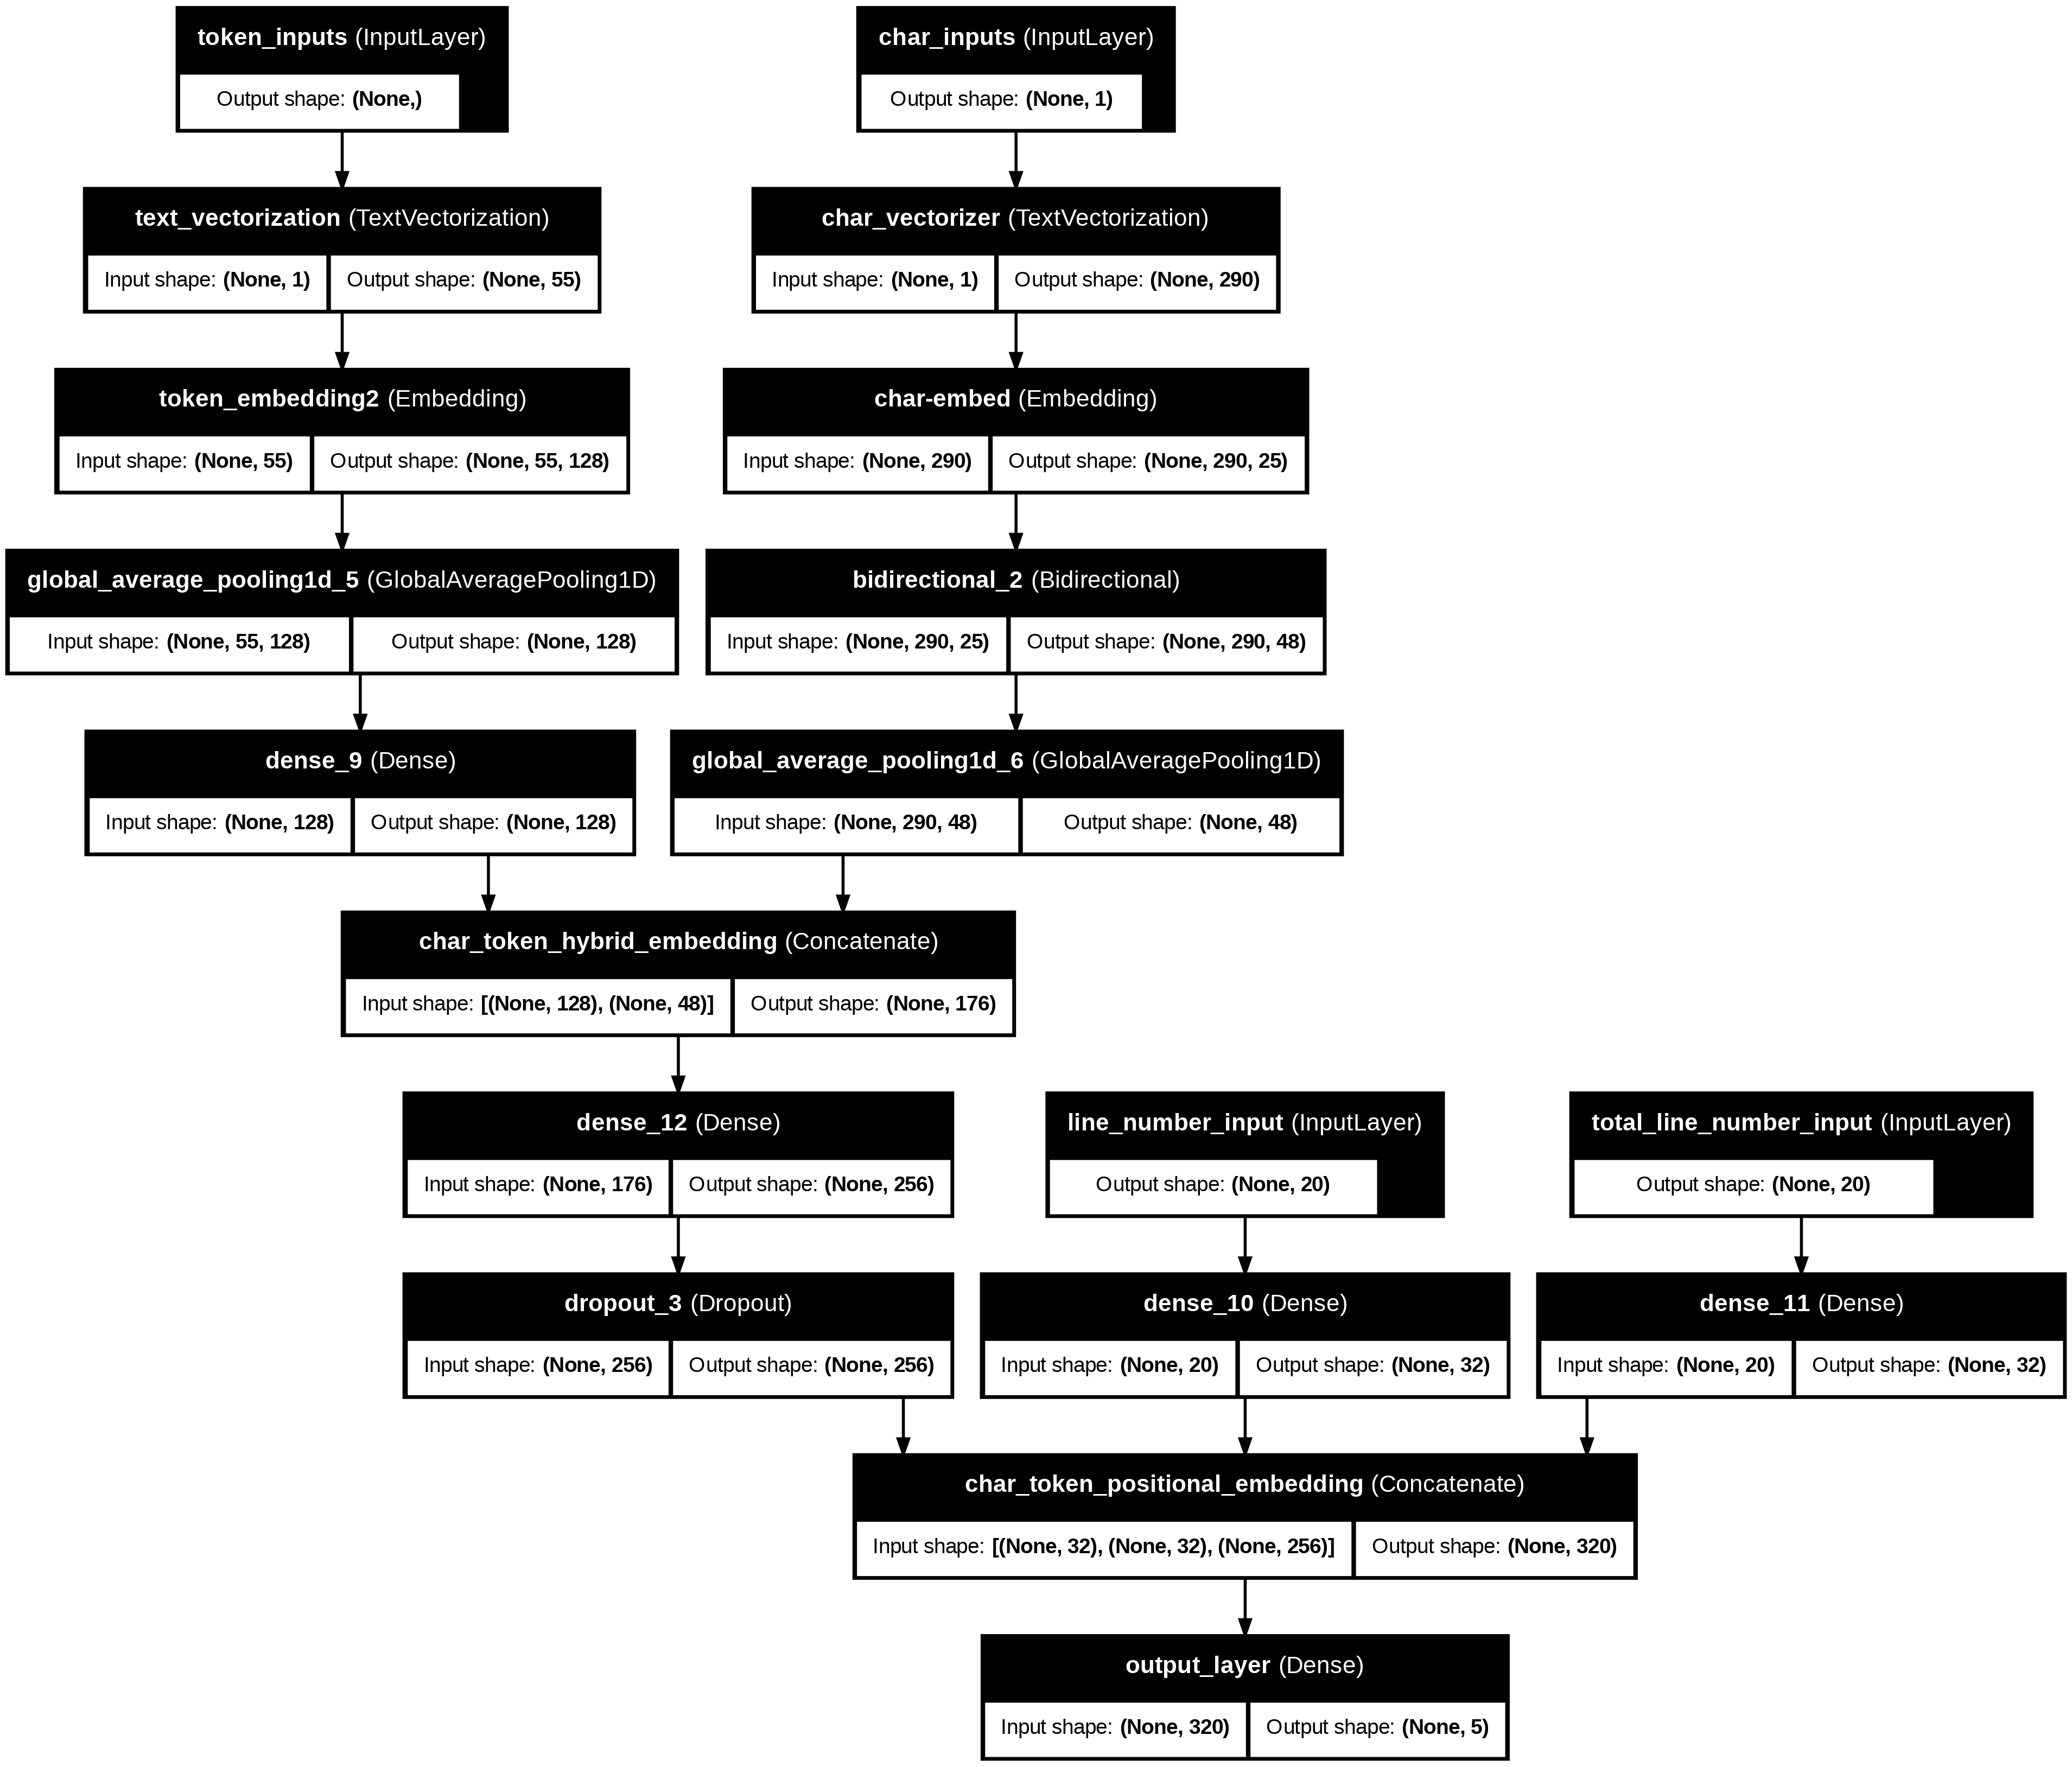

In [146]:
# Plot Hybrid token and character model

from tensorflow.keras.utils import plot_model

plot_model(model_5, show_shapes = True, show_layer_names = True)

In [147]:
# Compile token, char and positional embedding model

model_5.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), # helps to prevent overfitting
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
    )

## Create tribid embedding datasets using tf.data

In [148]:
# Create training and validation datasets (with all four kinds of input data)

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,
    train_total_lines_one_hot,
    train_sentences,
    train_chars
    ))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))

train_char_token_pos_dataset = tf.data.Dataset.zip((
    train_char_token_pos_data,
    train_char_token_pos_labels
    ))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,
    val_total_lines_one_hot,
    val_sentences,
    val_chars
))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))

val_char_token_pos_dataset = tf.data.Dataset.zip((
    val_char_token_pos_data,
    val_char_token_pos_labels
))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [149]:
# check input shapes

train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting, Evaluating and making predictions with our tribid model

In [150]:
# Fit our tribid embedding model

history_model_5 = model_5.fit(
    train_char_token_pos_dataset,
    steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
    epochs = 5,
    validation_data = val_char_token_pos_dataset,
    validation_steps = int(0.1 * len(val_char_token_pos_dataset))
)

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7013 - loss: 1.1237 - val_accuracy: 0.8165 - val_loss: 0.9462
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.8583 - loss: 0.9014 - val_accuracy: 0.8388 - val_loss: 0.9026
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.8669 - loss: 0.8885 - val_accuracy: 0.8135 - val_loss: 0.9246
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.8703 - loss: 0.8803 - val_accuracy: 0.8464 - val_loss: 0.9093
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.8722 - loss: 0.8835 - val_accuracy: 0.8215 - val_loss: 0.9368


In [151]:
# Make predictions with the char token pos model

model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


array([[0.5996434 , 0.08099529, 0.0232299 , 0.2632467 , 0.03288468],
       [0.5713869 , 0.08837829, 0.08164339, 0.21678755, 0.04180386],
       [0.19009386, 0.08096969, 0.05902364, 0.63139147, 0.03852134],
       ...,
       [0.0292021 , 0.04857697, 0.02144995, 0.02812666, 0.87264436],
       [0.04715114, 0.8094179 , 0.02300906, 0.02427338, 0.09614848],
       [0.14105849, 0.75667685, 0.03729196, 0.01793153, 0.04704118]],
      dtype=float32)

In [152]:
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [153]:
model_5_results = calculate_results(y_true = val_labels_encoded, y_pred = model_5_preds.numpy())
model_5_results

{'accuracy': 81.75890374685555,
 'precision': 0.8424738496406421,
 'recall': 0.8175890374685555,
 'f1': 0.8171518794206409}

## Compare our model results

In [154]:
# Combine model results into a dataframe

all_model_results = pd.DataFrame({
    'model_0_baseline_results' : baseline_results,
    'model_1_results': model_1_results,
    'model_2_results': model_2_results,
    'model_3_results': model_3_results,
    'model_4_results': model_4_results,
    'model_5_results': model_5_results
    })

In [155]:
all_model_results

,model_0_baseline_results,model_1_results,model_2_results,model_3_results,model_4_results,model_5_results
accuracy,72.183238,80.103932,74.755064,73.447637,75.867205,81.758904
precision,0.718647,0.801973,0.744054,0.732056,0.778237,0.842474
recall,0.721832,0.801039,0.747551,0.734476,0.758672,0.817589
f1,0.698925,0.797725,0.742419,0.729363,0.763779,0.817152


In [156]:
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline_results,72.183238,0.718647,0.721832,0.698925
model_1_results,80.103932,0.801973,0.801039,0.797725
model_2_results,74.755064,0.744054,0.747551,0.742419
model_3_results,73.447637,0.732056,0.734476,0.729363
model_4_results,75.867205,0.778237,0.758672,0.763779
model_5_results,81.758904,0.842474,0.817589,0.817152


In [157]:
# Reduce the accuracy to same scale as the other metrics

all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline_results,0.721832,0.718647,0.721832,0.698925
model_1_results,0.801039,0.801973,0.801039,0.797725
model_2_results,0.747551,0.744054,0.747551,0.742419
model_3_results,0.734476,0.732056,0.734476,0.729363
model_4_results,0.758672,0.778237,0.758672,0.763779
model_5_results,0.817589,0.842474,0.817589,0.817152


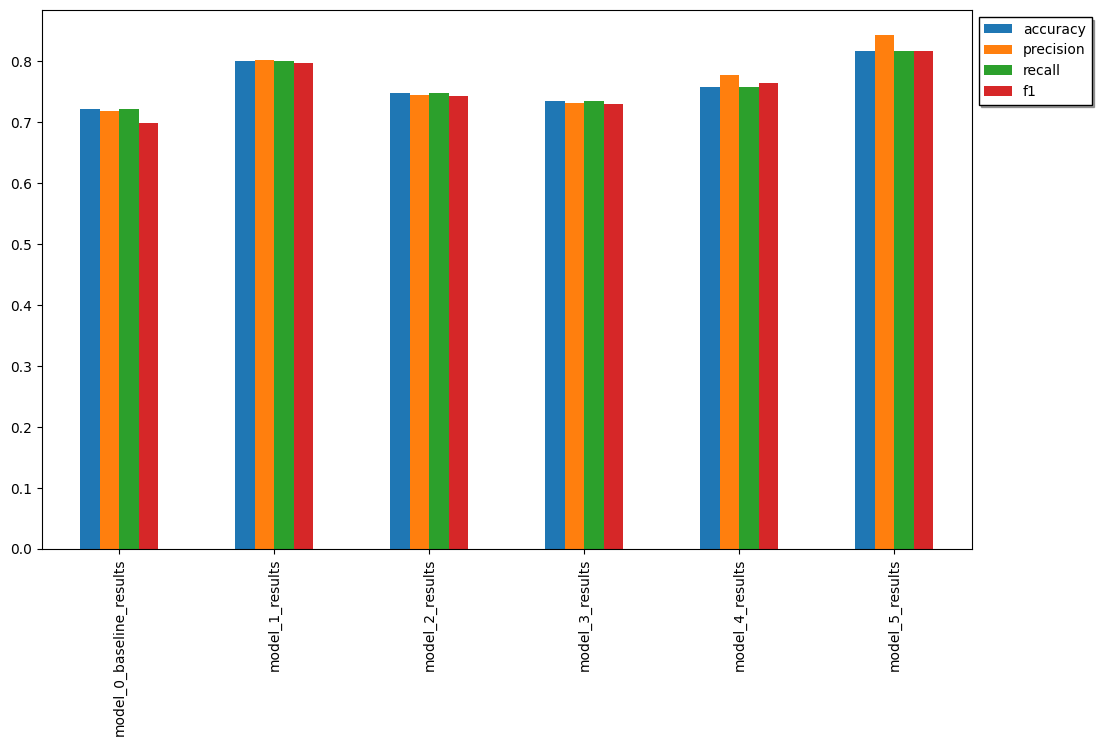

In [161]:
# plot and compare all model results

all_model_results.plot(kind = 'bar', figsize = (12,7))
plt.legend(bbox_to_anchor = (1,1), fancybox = False, edgecolor = 'k', shadow = True)
plt.show()

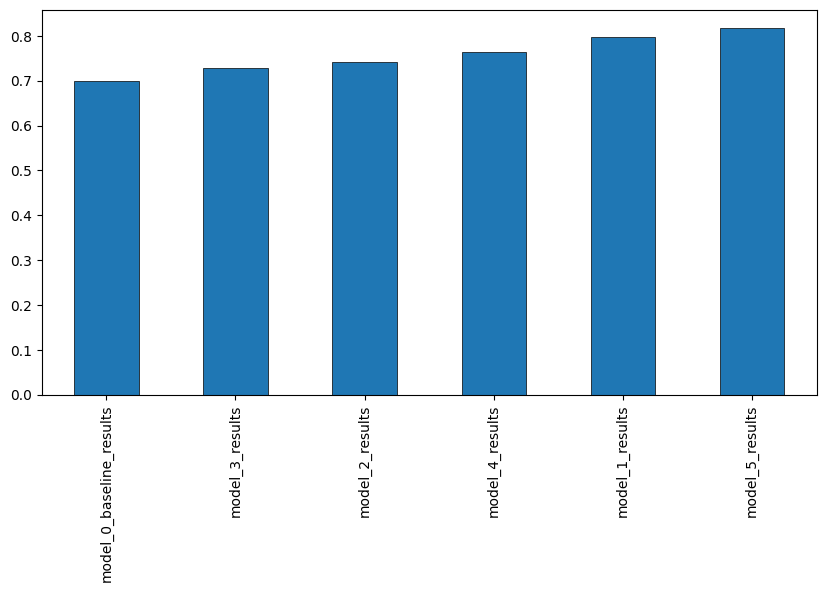

In [164]:
# Sort model results by F1_score

all_model_results.sort_values('f1', ascending = True)['f1'].plot(kind = 'bar', figsize = (10,5), edgecolor = 'k', lw = 0.5)
plt.show()

## Save and Load the model

In [166]:
# Save the best performing model to SavedModel format (default)

model_5.save('skimlit_tribid_model.keras') # or we can save it as .h5(.hdf5) format

In [169]:
model_5.save('skimlit_tribid_model.h5') # this file format is deprecated

In [167]:
# Load in best performing model

loaded_model = tf.keras.models.load_model('skimlit_tribid_model.keras')

In [168]:
loaded_model.evaluate(val_char_token_pos_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.8155 - loss: 0.9421


[0.9424837231636047, 0.8175890445709229]

In [170]:
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step


array([[0.5996434 , 0.08099529, 0.0232299 , 0.2632467 , 0.03288468],
       [0.5713869 , 0.08837829, 0.08164339, 0.21678755, 0.04180386],
       [0.19009386, 0.08096969, 0.05902364, 0.63139147, 0.03852134],
       ...,
       [0.0292021 , 0.04857697, 0.02144995, 0.02812666, 0.87264436],
       [0.04715114, 0.8094179 , 0.02300906, 0.02427338, 0.09614848],
       [0.14105849, 0.75667685, 0.03729196, 0.01793153, 0.04704118]],
      dtype=float32)

In [172]:
# Calculate the results of our loaded model

loaded_model_preds = tf.argmax(loaded_pred_probs, axis = 1)
loaded_model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [173]:
# calculate the results for our loaded model

loaded_model_results = calculate_results(y_true = val_labels_encoded, y_pred = loaded_model_preds.numpy())
loaded_model_results

{'accuracy': 81.75890374685555,
 'precision': 0.8424738496406421,
 'recall': 0.8175890374685555,
 'f1': 0.8171518794206409}

In [174]:
model_5_results

{'accuracy': 81.75890374685555,
 'precision': 0.8424738496406421,
 'recall': 0.8175890374685555,
 'f1': 0.8171518794206409}